In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyale

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.model_selection import KFold, cross_val_score, ParameterGrid
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np
np.int = int
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.utils import shuffle
import shap
shap.initjs()
from PyALE import ale
from scipy.stats import friedmanchisquare
import itertools

In [32]:
#read input data
df_input = pd.read_csv('flow-cell.csv', index_col=0)

#filter input data
indices_to_remove_input = ['FE']
filtered_input = df_input.drop(indices_to_remove_input)
filtered_input = filtered_input.fillna(0) # fill  empty cells with 0
filtered_input = filtered_input.transpose() # change positions of columns and rows
filtered_input = filtered_input.loc[:, :'t [min]'] # remove columns after certain column
filtered_input = filtered_input.drop(['21065', '21090', '21091', '21097', '21092', '21080']) # remove outlier
#print(filtered_input)

#filter output data
df_output = pd.read_csv('flow-cell.csv', index_col=0)
filtered_output = df_output.loc['CE fuel [%]':, :,] # remove columns after certain column
filtered_output = filtered_output.fillna(0) # fill  empty cells with 0
filtered_output = filtered_output.transpose() # change positions of columns and rows
filtered_output = filtered_output.drop(['21065', '21090', '21091', '21097', '21092', '21080']) # remove outlier
#print(filtered_output)

output = 'Ydecane total acid [%]'
output_name = 'total yield' # for correlation matrix
X = filtered_input.values
Y = filtered_output[output].values
#print(X)
features = [0, 1, 2, 3]
feature_names = ['pH start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']

random_state_counter = 45
#print(filtered_input)

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state_counter)
knn_regressor = Pipeline([
    ('scaler_std', StandardScaler()),
    ('scaler_minmax', MinMaxScaler()),  
    ('knn', KNeighborsRegressor(n_neighbors=3, weights='distance', p=2))
])

knn_regressor.fit(X_train, Y_train)

Y_predict_train_knn = knn_regressor.predict(X_train)
Y_predict_test_knn = knn_regressor.predict(X_test)


mse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn)
rmse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn, squared=False)
r2_train_knn = r2_score(Y_train, Y_predict_train_knn)

mse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn)
rmse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn, squared=False)
r2_test_knn = r2_score(Y_test, Y_predict_test_knn)

print("MSE on train set:", mse_train_knn )
print("RMSE on train set:", rmse_train_knn)
print("R2 on train set:", r2_train_knn)
print("MSE on test set:", mse_test_knn )
print("RMSE on test set:", rmse_test_knn)
print("R2 on test set:", r2_test_knn)


MSE on train set: 31.256423551169597
RMSE on train set: 5.5907444541107045
R2 on train set: 0.7203478582440899
MSE on test set: 13.819194834874404
RMSE on test set: 3.7174177643727915
R2 on test set: 0.8384606561771465


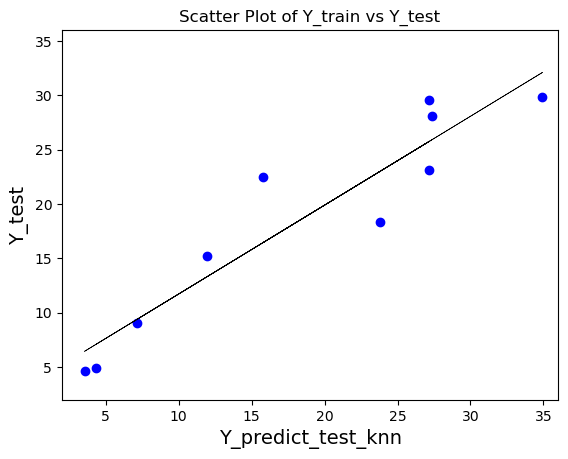

In [118]:
# Linear fit
slope, intercept = np.polyfit(Y_predict_test_knn, Y_test, 1)
fit_line = slope * Y_predict_test_knn + intercept

plt.plot(Y_predict_test_knn, fit_line, color='black', linestyle='-', label='Linear Fit', lw=0.5)
plt.scatter(Y_predict_test_knn, Y_test, color='blue', label='Scatter Points')
plt.title('Scatter Plot of Y_train vs Y_test')
plt.xlabel('Y_predict_test_knn')
plt.ylabel('Y_test')
plt.xlim([2, 36])  # Set x-axis range
plt.ylim([2, 36])  # Set y-axis range
plt.show()

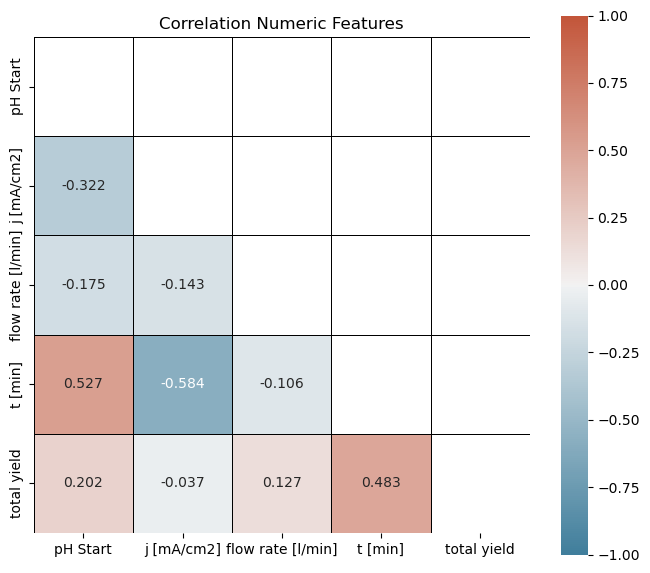

In [109]:
# correlation matrix
df_XY = filtered_input
df_XY[output_name] = filtered_output[output]

corr_df = df_XY.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(
    data=corr_df,
    mask=mask,
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)
ax.set(title='Correlation Numeric Features');

In [50]:
# SHAPLEY values
explainer = shap.KernelExplainer(knn_regressor.predict, X_train)
instance_index = 5  # Replace with the index of the instance you want to explain
shap_value = explainer.shap_values(X_test[instance_index])
shap.force_plot(explainer.expected_value, shap_value, X_test[instance_index], feature_names=feature_names)



100%|██████████| 48/48 [00:00<00:00, 152.62it/s]


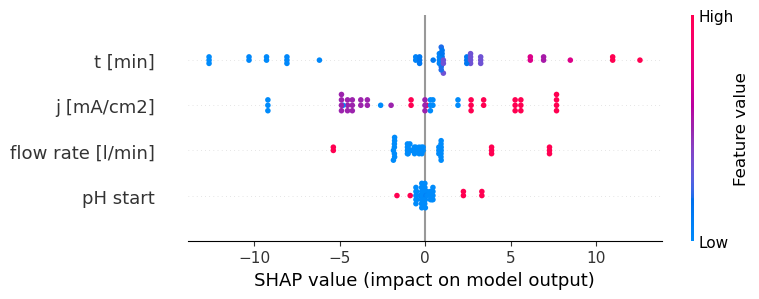

In [120]:
shap_data = X
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data, feature_names=feature_names)

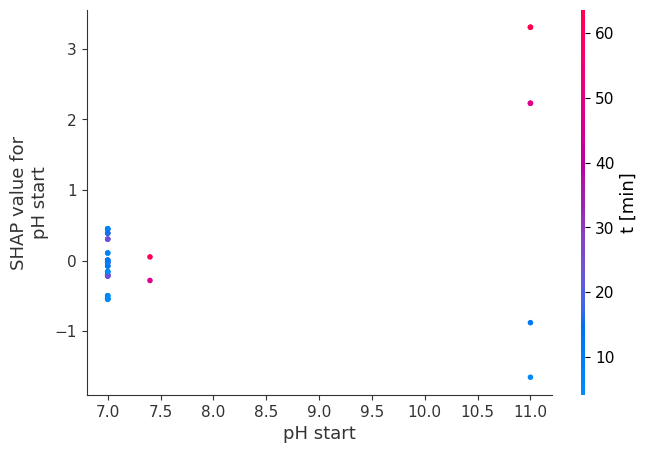

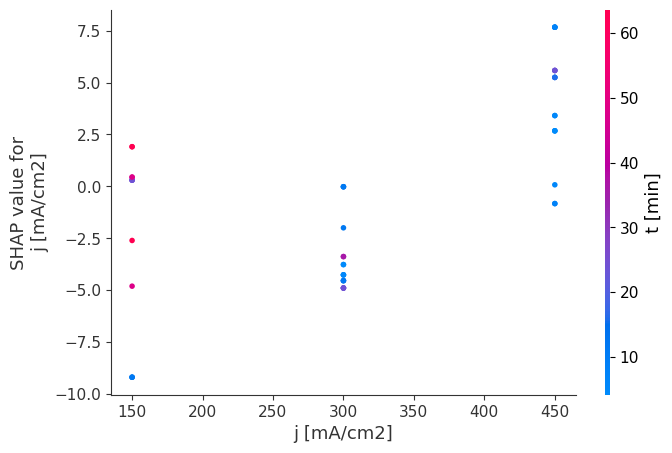

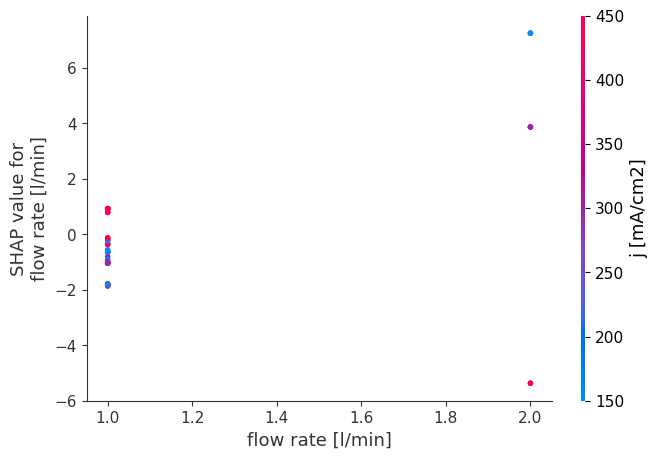

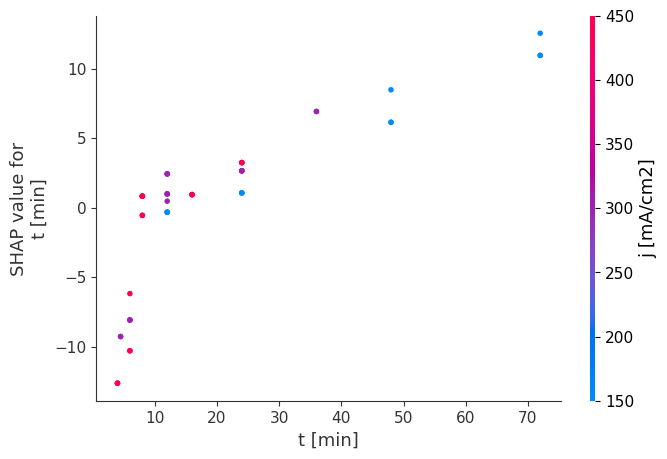

In [121]:
# Create a SHAP dependence plot

for i in features:
    shap.dependence_plot(i, shap_values, shap_data, feature_names=feature_names)

In [59]:
df_test=pd.DataFrame({"test": Y_test, "prediction": Y_predict_test_knn})
print(df_test)

     test  prediction
0  28.062   27.394000
1   9.071    7.113500
2  23.123   27.167942
3  22.444   15.792500
4  29.880   34.928000
5  15.243   11.952000
6   4.681    3.545000
7  18.379   23.830000
8  29.554   27.167942
9   4.901    4.353500


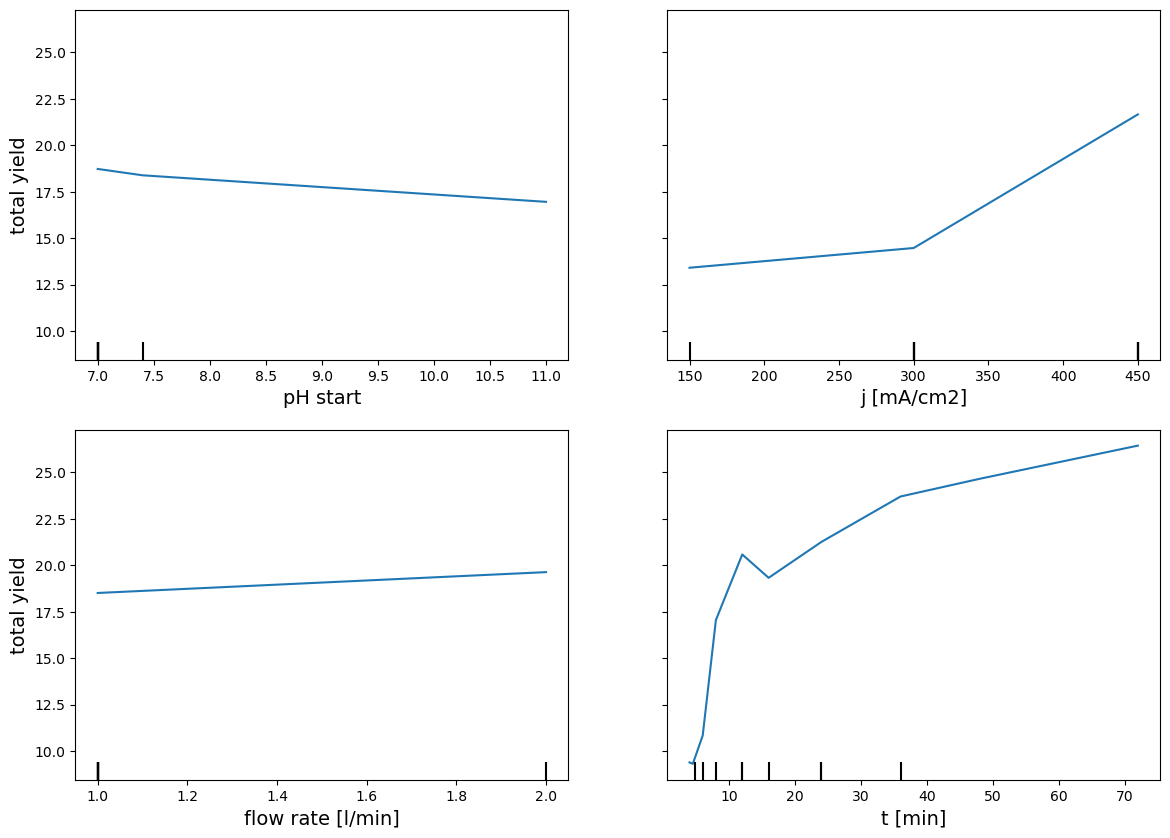

In [35]:
ax_labelsize = 14
tick_labelsize = 10

nrows = 2 
ncols = 2 
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
ax[0, 0].set_ylabel(y_label)
ax[1, 0].set_ylabel(y_label)


display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, ax=ax#, line_kw={"color": "green"}
                                                 )

Text(0, 0.5, 'total yield')

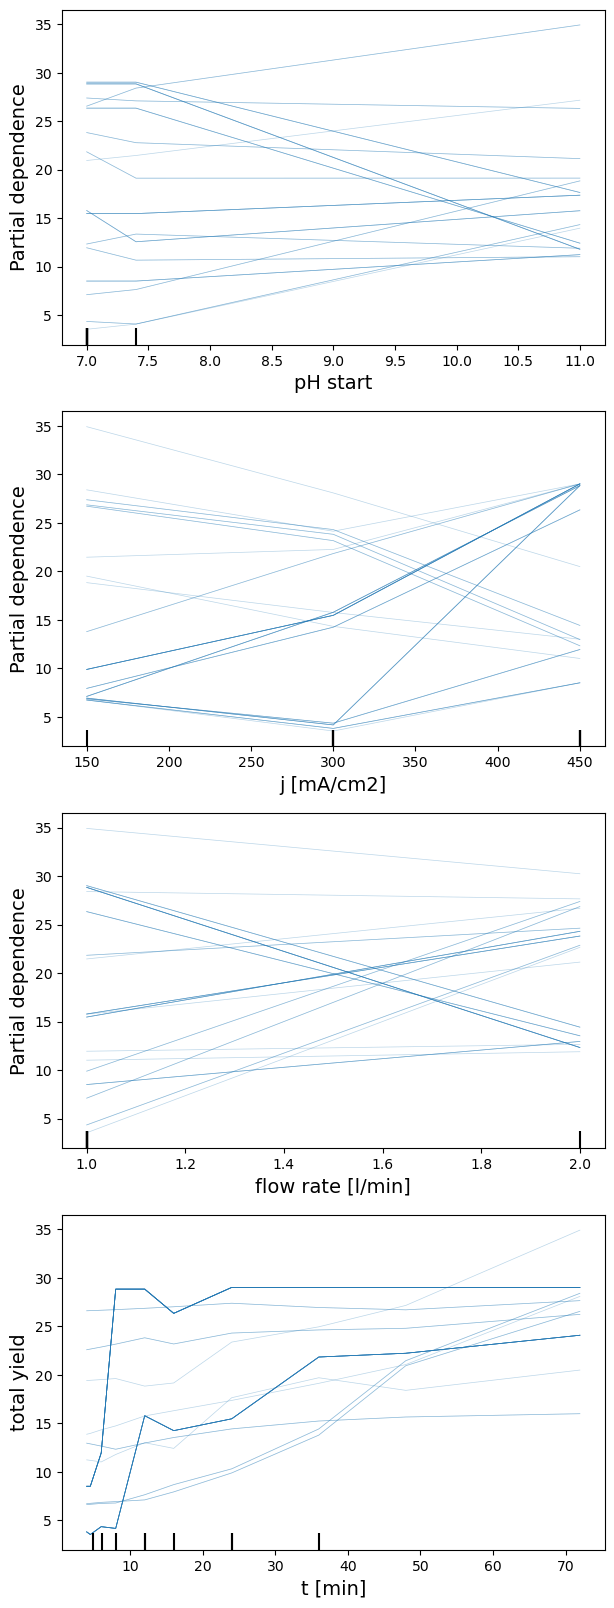

In [45]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 20))
display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, ax=ax, kind='individual')#,  line_kw={"color": "green"}
ax[3].set_ylabel('total yield')

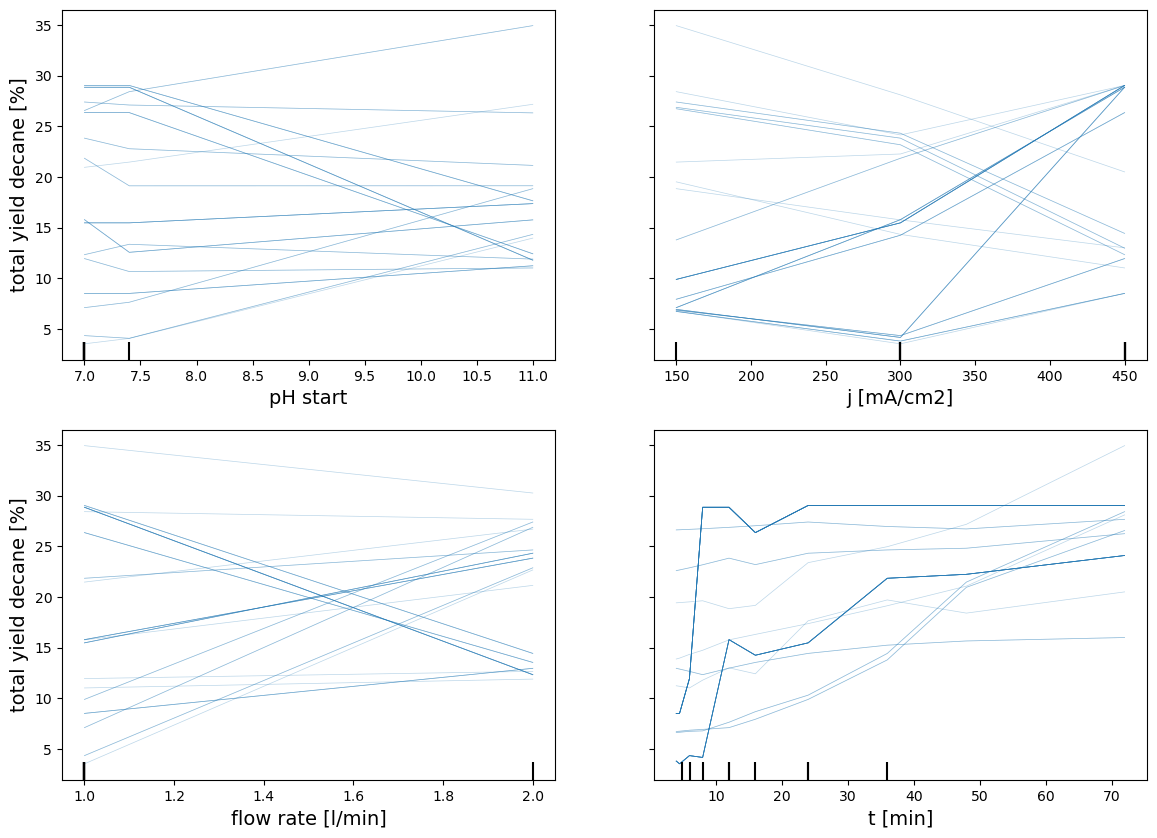

In [106]:
#  Individual conditional expectation (ICE) plot (single instead of averages) 
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
 
ax[0, 0].set_ylabel(y_label)
ax[1, 0].set_ylabel(y_label)

features = [0, 1, 2, 3]
feature_names = ['pH start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']
display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='individual', ax=ax)

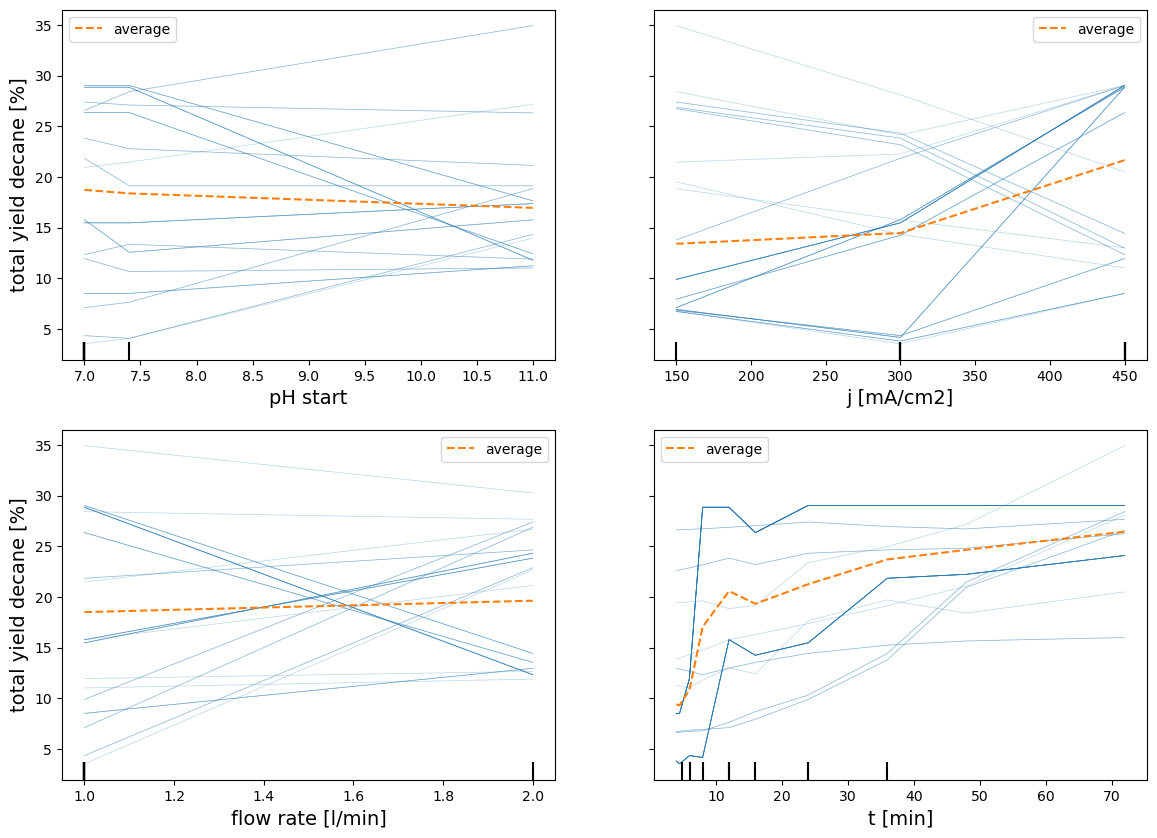

In [108]:
# cICE (centered ICE) and PDP
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
  
ax[0, 0].set_ylabel(y_label)
ax[1, 0].set_ylabel(y_label)

features = [0, 1, 2, 3]
feature_names = ['pH start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']
display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='both', ax=ax)

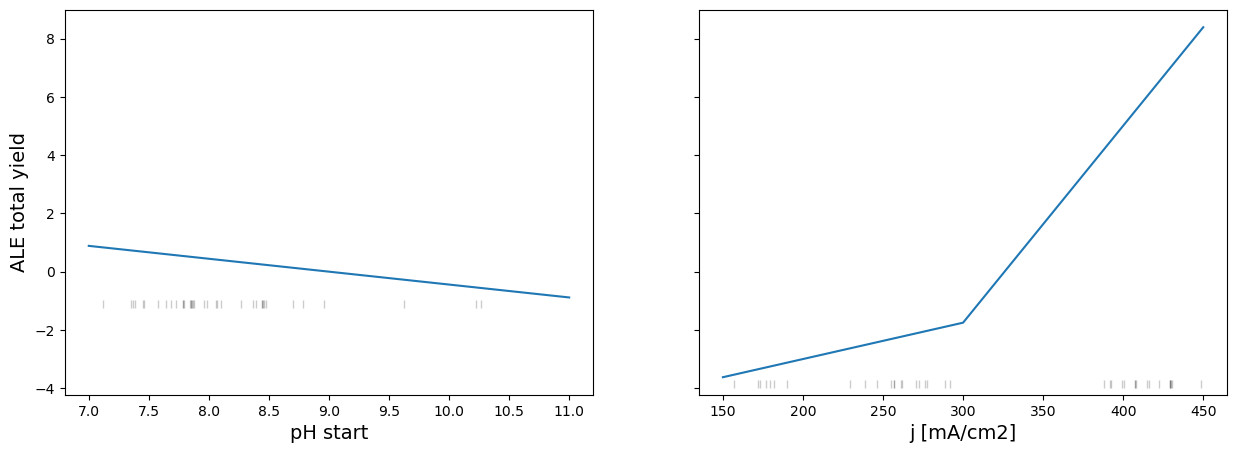

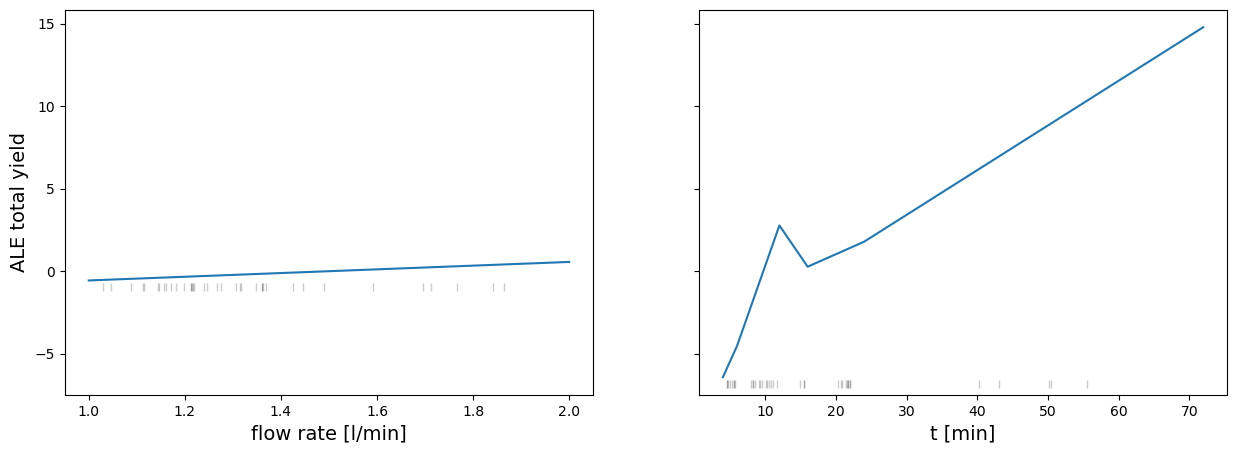

In [107]:
df_train_X = pd.DataFrame(X_train, columns=features)
df_train_Y = pd.DataFrame(Y_train, columns=['total_yield'])

# get ALE plot

for i in features:
    if i % 2 == 0:
        fig, ax = plt.subplots(ncols=ncols, figsize=(15, 5), sharey=True)
        for axis in ax.flatten():
            axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
        ale_eff = ale(
            X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
            fig=fig, ax=ax[0]
        )
        ax[0].set_ylabel('ALE total yield')
        ax[0].set_xlabel(feature_names[i])
        ax[0].set_title('')
    else:
        ale_eff = ale(
        X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
        fig=fig, ax=ax[1]
        )
        ax[1].set_ylabel('')
        ax[1].set_xlabel(feature_names[i])
        ax[1].set_title('')
    

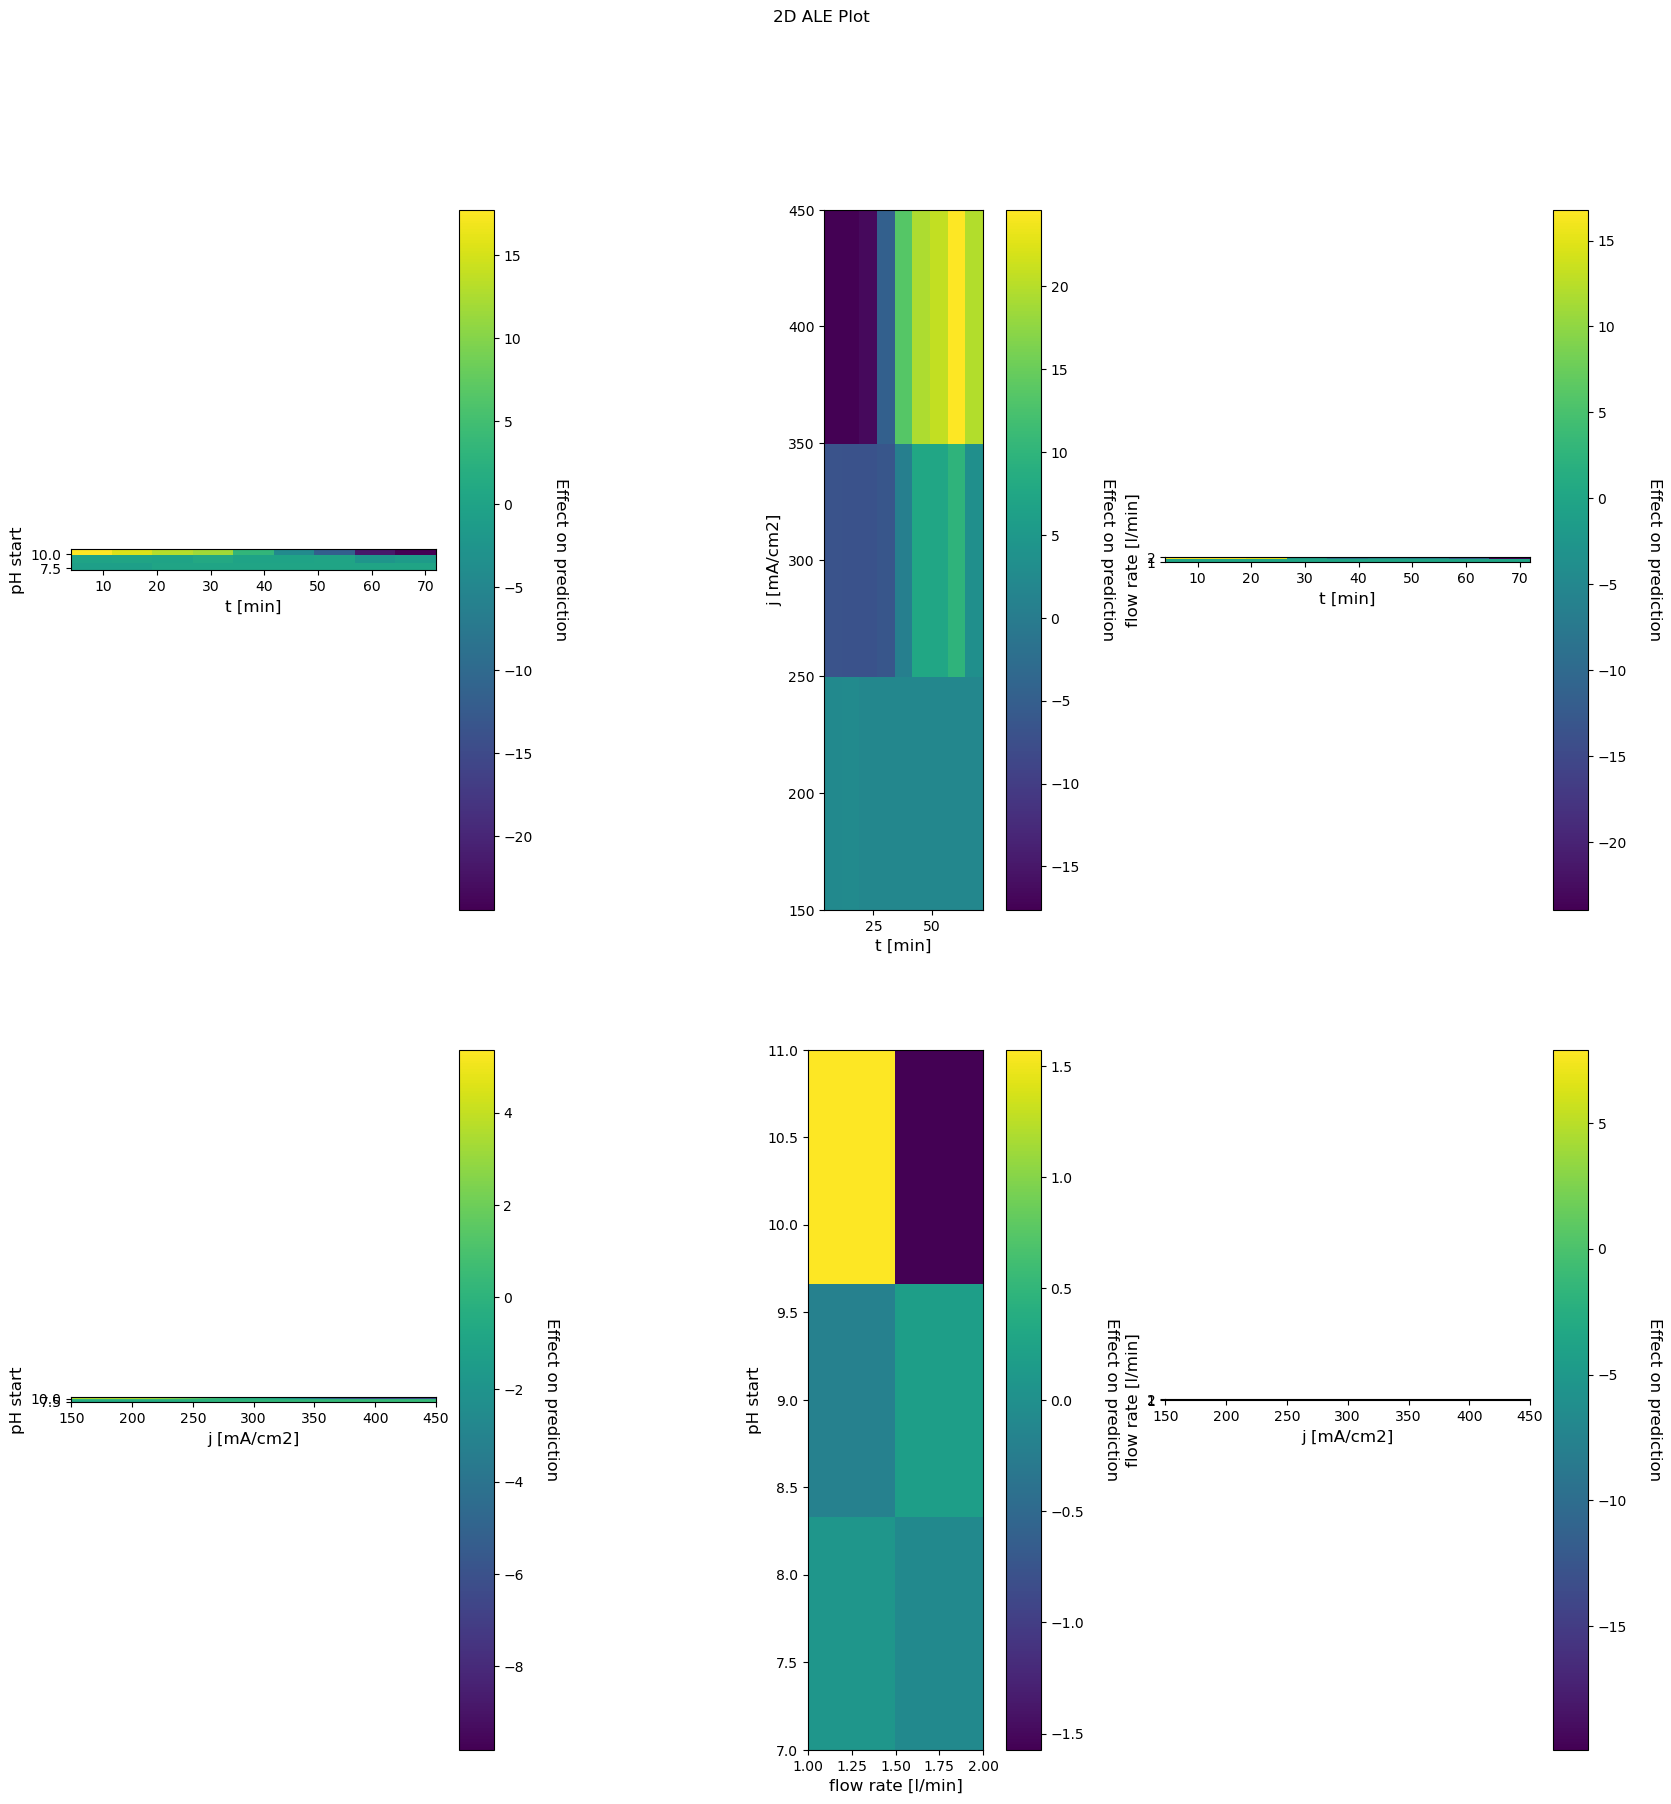

In [77]:
# 2D ale plots

df_train_X = pd.DataFrame(X_train, columns=feature_names)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 20))
for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[feature_names[0], "t [min]"], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
    fig=fig, ax=ax[0, 0]
)
ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[feature_names[1], "t [min]"], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
    fig=fig, ax=ax[0,1]
)
ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[feature_names[2], "t [min]"], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
    fig=fig, ax=ax[0,2]
)
ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[feature_names[0], feature_names[1]], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
    fig=fig, ax=ax[1,0]
)
ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[feature_names[0], feature_names[2]], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
    fig=fig, ax=ax[1,1]
)
ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[feature_names[2], feature_names[1]], grid_size=10, include_CI=False, #C=0.95,
    fig=fig, ax=ax[1,2]
)
#ax.set_ylabel('ALE total yield')
#ax.set_xlabel(feature_names[i])
#ax.set_title('')



                       Mean   Std Dev
pH Start           0.073838  0.055828
j [mA/cm2]         0.199833  0.102286
flow rate [l/min]  0.283155  0.155449
t [min]            0.443175  0.155037


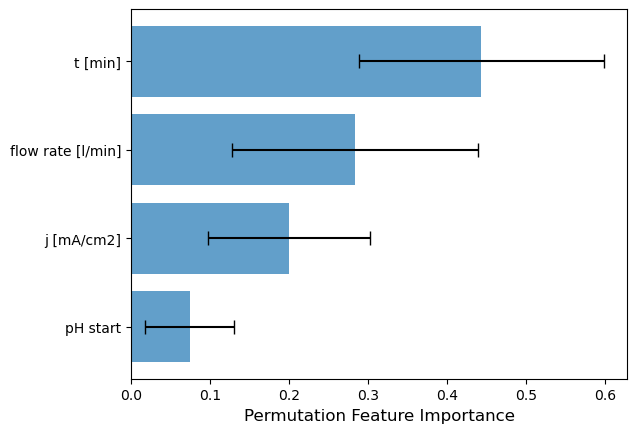

In [87]:
# permutation feature importance on test data

# Initialize data frame
df_feature_importances=pd.DataFrame(columns=['pH Start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]'])

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_test)
baseline_mse = mse(Y_test, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_test.shape[1])

runs = 500

for j in range(runs+1):
    
    # Perform permutation feature importance
    for i in range(X_test.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_test, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    df_feature_importances.loc[len(df_feature_importances)] = feature_importances

# Drop the first row after the loop as it is the same to the 2nd
df_feature_importances = df_feature_importances.drop(0, axis=0).reset_index(drop=True)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = ['pH Start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(feature_names)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.show()

                       Mean   Std Dev
pH Start           0.028513  0.028414
j [mA/cm2]         0.406118  0.083054
flow rate [l/min]  0.194672  0.052873
t [min]            0.370697  0.072512


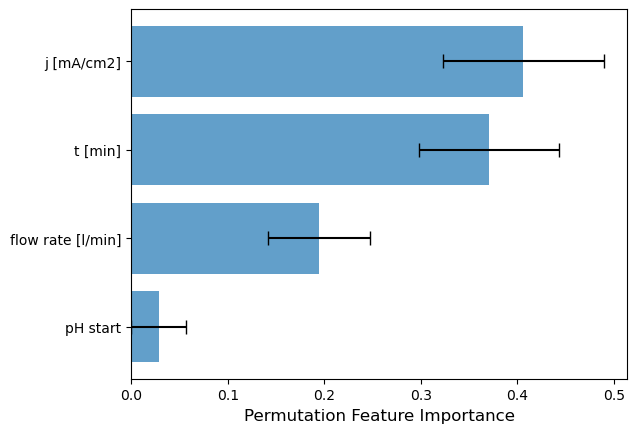

In [88]:
# permutation feature importance on training data

# Initialize data frame
df_feature_importances=pd.DataFrame(columns=['pH Start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]'])

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_train)
baseline_mse = mse(Y_train, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_train.shape[1])

runs = 500

for j in range(runs+1):
    
    # Perform permutation feature importance
    for i in range(X_train.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_train.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_train, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    df_feature_importances.loc[len(df_feature_importances)] = feature_importances

# Drop the first row after the loop as it is the same to the 2nd
df_feature_importances = df_feature_importances.drop(0, axis=0).reset_index(drop=True)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = ['pH Start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(feature_names)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.show()